In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import torch

## Autograd
- `requires_grad=True` enables tensor history tracking and allows for automatic differentiation
    - construction of a acyclic directed *computation graph* 
- For a given tensor `X`:
  - `X.grad_fn` object stores this tensor's gradient function
  - `X.grad_fn.next_functions` points to other gradient functions 


In [18]:
x = torch.ones(1, requires_grad=True)
y = x**2
print(y.grad_fn)

In [19]:
z = y + 3
print(z.grad_fn, z.grad_fn.next_functions)

<AddBackward object at 0x7fd0759e0278> ((<PowBackward0 object at 0x7fd0759f6860>, 0),)


### The `backward` method
- `backward` computes gradients with respect to graph leaves by chain-rule (starting from root)
- here: $z= y + 3 =x^2 + 3$ , so $\frac{dz}{dx} = \frac{dz}{dy}\frac{dy}{dx}=2x$ 
  - `z` is the root (on which we are calling backward)
  - `x` is the only leaf

In [20]:
z.backward()

- after the call:
  - `x.data` contains `x` values
  - `x.grad` will store gradients computed wrt. `x`

In [21]:
print('x: ', x.data)
print('dz/dx: ', x.grad)

x:  tensor([1.])
dz/dx:  tensor([2.])


- previously computation graph is erased (except if `retain_graph=True` is used)

In [22]:
#z.backward(x)

### Dynamic graphs
- A computation dependency graph allows automaticaly computing gradients by chain-rule
- Define-and-run: graph can be changed in the loop before next call to backward (flexibility!)
<center>
    <img 
         align="middle"
         src = "https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif"  
         width=900/>
    Source: https://github.com/pytorch/pytorch
</center>

### Example: a simple regression
- Goal: make `x` approach `target`
- gradient descent: update `x.data` in the oposite direction of `x.grad`

Let's pick a target (blue) and take a starting point (orange):

In [23]:
def plot(x, target):
    plt.plot(target.numpy(), 'o ', ms=20, label= 'target')
    plt.plot(x.data.numpy(), '* ', ms=20, label='variable x'); plt.legend()
    print('x: ', x, '\ntarget:', target)

x:  tensor([0.6167, 0.1571, 0.7954, 0.3265, 0.2101], requires_grad=True) 
target: tensor([0., 1., 2., 3., 4.])


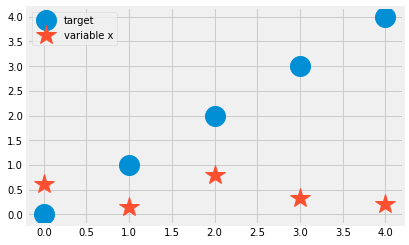

In [24]:
x = torch.rand(5, requires_grad=True)
target = torch.arange(5.0)

plot(x,target)

Then we loop over gradient computation and minimzation steps. 

**Note**: modificatios to `x.data` are not monitored by `autograd`.

x:  tensor([0.0014, 0.9982, 1.9974, 2.9941, 3.9917], requires_grad=True) 
target: tensor([0., 1., 2., 3., 4.])


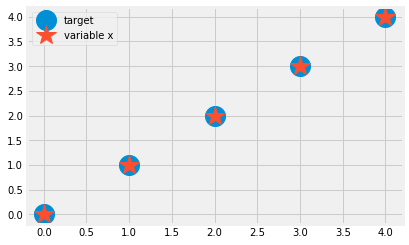

In [25]:
lr = learning_rate = 0.1
for _ in range(150):
    # compute squared distance between x and target
    distance = torch.mean(torch.pow((x - target), 2))
    distance.backward(retain_graph=True)
    # update x.data according to x.grad
    x.data -=  lr * x.grad.data
    # backward accumulates gradients, so zero them before next call to backward
    x.grad.zero_()  # (.zero_ method fills tensors with 0s in-place)

plot(x, target)

### Example: Logistic regression
Let's work on some synthetic data

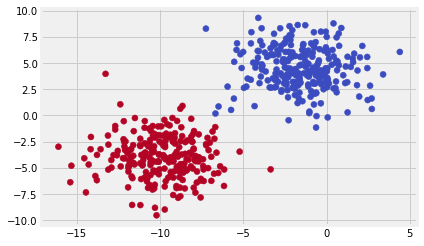

In [26]:
from sklearn.datasets import make_blobs

n_classes = 2
X, y = make_blobs(n_samples=500, n_features=2, centers=n_classes, 
                  cluster_std=2, random_state=1)
plt.scatter(*X.T, c=y, cmap='coolwarm')

#### Declare parameters to be adjusted
This is the logistic regression prediction:
$$ y = \sigma (XW + b )$$
This is the optmization problem based on a mean squared error cost function:
$$\min_{W,b} (y-\hat{y})^2$$
The logistic regression predictor has two parameters: 
- the weight matrix `W` and 
- the vector of intercepts `b`

In [27]:
n_samples, n_features = X.shape
# we can set random generator's seed
torch.manual_seed(0)
W = torch.rand(n_features, n_classes, # tensor shape
               dtype=torch.double, requires_grad=True)  

b = torch.zeros(n_classes, # tensor shape
                dtype=torch.double, requires_grad=True)


Since the graph for gradient computation is defyned by run, **all steps need to be recomputed at every iteration**.
We'll have the following steps:
- compute the logistic regressor predictions
- compute a loss function measuring the prediction error
- call `backward` on the `loss` tensor
- update `W.data` and `b.data` with the gradients `W.grad` and `b.grad`
- reset `W.grad` and `b.grad` to zero

In [28]:
# Loop to optimize
n_iterations = 500
lr = 0.1
loss_curve = []
for i in range(n_iterations):
    # compute the logistic regressor output
    X_tensor = torch.from_numpy(X)
    linear = torch.mm(X_tensor, W) + b
    y_pred = torch.sigmoid(linear)
    
    # Let's encode the true class labels in a matrix of class indicator vectors
    # (one-hot encoding) so we can compare to our predictions
    y_true = torch.zeros(n_samples, n_classes, dtype=y_pred.dtype)
    y_true.scatter_(1, torch.from_numpy(y).view(-1,1), 1.0)
    
    # Now we define a MSE loss function between predictions 
    loss = (y_pred-y_true).pow(2).mean()
    loss_curve.append(loss.data.numpy())
    # loss backward computes gradients
    loss.backward(retain_graph=True) 
    
    # Let's update the parameters with the respective gradients
    # the .sub_ method subtracts from the tensor in-place
    W.data.sub_(lr * W.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # reset gradients to zero
    W.grad.data.zero_()
    b.grad.data.zero_()

##### Results

In [29]:
def frontier_plot():
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    new_x = np.c_[xx.ravel(), yy.ravel()]
    Z = torch.sigmoid(torch.from_numpy(new_x).mm(W)+b).data.numpy()[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='coolwarm', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)


Final accuracy:  98.8


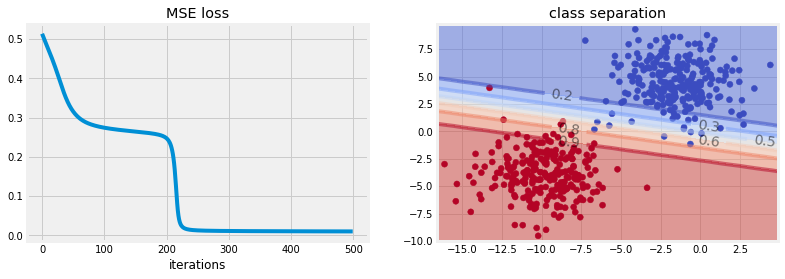

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_curve)
plt.title('MSE loss'); plt.xlabel('iterations')
plt.subplot(1,2,2)
plt.title('class separation')
frontier_plot()
plt.scatter(*X.T, c=y, cmap='coolwarm')
y_pred_class = torch.argmax(y_pred, 1).detach().numpy()
print('Final accuracy: ', (y_pred_class == y).mean()*100)